# Implementing Loss Function

Loss functions are very important to machine learning algorithms. They measure the distance between the model outputs and the target (truth) values.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

sess = tf.Session()

In [2]:
def createLossFn(fn):
    def runFn(pair):
        return fn(pair[0], pair[1])
    return runFn

def plotLoss(fnInfos, predictions, labels, title='', createFn=None):
    %matplotlib notebook
    
    if type(fnInfos) is not list:
        fnInfos = [fnInfos]

    if createFn is None:
        createFn = createLossFn
        
    for fnInfo in fnInfos:
        fn = fnInfo['fn']
        y = tf.map_fn(fn=createFn(fn), elems=tf.stack([labels, predictions], axis=1))
        plt.plot(sess.run(predictions), sess.run(y), ':', linewidth=1.5)
        
    plt.xlabel('prediction')
    plt.ylabel('loss')
    plt.title(title)
    plt.legend([fnInfo['name'] for fnInfo in fnInfos])
    plt.show()

## Loss function for regression

In [3]:
n = 100

predictions = tf.linspace(start=-1., stop=1., num=n, name='predictions')
labels = tf.zeros(shape=[n], dtype=tf.float32, name='labels')
error = tf.subtract(predictions, labels, name='error')

print(predictions)
print(labels)
print(error)

Tensor("predictions:0", shape=(100,), dtype=float32)
Tensor("labels:0", shape=(100,), dtype=float32)
Tensor("error:0", shape=(100,), dtype=float32)


In [4]:
def createRegressionFn(fn):
    def runFn(pair):
        return fn(labels=pair[0], predictions=pair[1])
    return runFn

def plotRegressionLoss(fnInfos, title='', predictions=None, labels=None, createFn=None):
    n = 200
    
    if predictions is None:
        predictions = tf.linspace(start=-1., stop=1., num=n)
    
    if labels is None:
        labels = tf.zeros(dtype=tf.float32, shape=[n])
        
#     if createFn is None:
#         createFn = createRegressionFn
    
    plotLoss(fnInfos=fnInfos, title=title, predictions=predictions, labels=labels, createFn=createFn)

### L2 norm (Euclidean) loss

The square of the distance to the target.

The L2 norm is a great loss function because it is very curved near the target and algorithms can use this fact to converge to the target more slowly, the closer it gets.

$$loss = (L - P)^2$$

where L is labels and P is predictions.

In [5]:
l2_loss_1 = tf.losses.mean_squared_error(predictions=predictions, labels=labels, weights=1)
sess.run(l2_loss_1)

0.34006733

In [6]:
l2_loss_2 = tf.reduce_mean(tf.square(error))
sess.run(l2_loss_2)

0.34006733

<IPython.core.display.Javascript object>


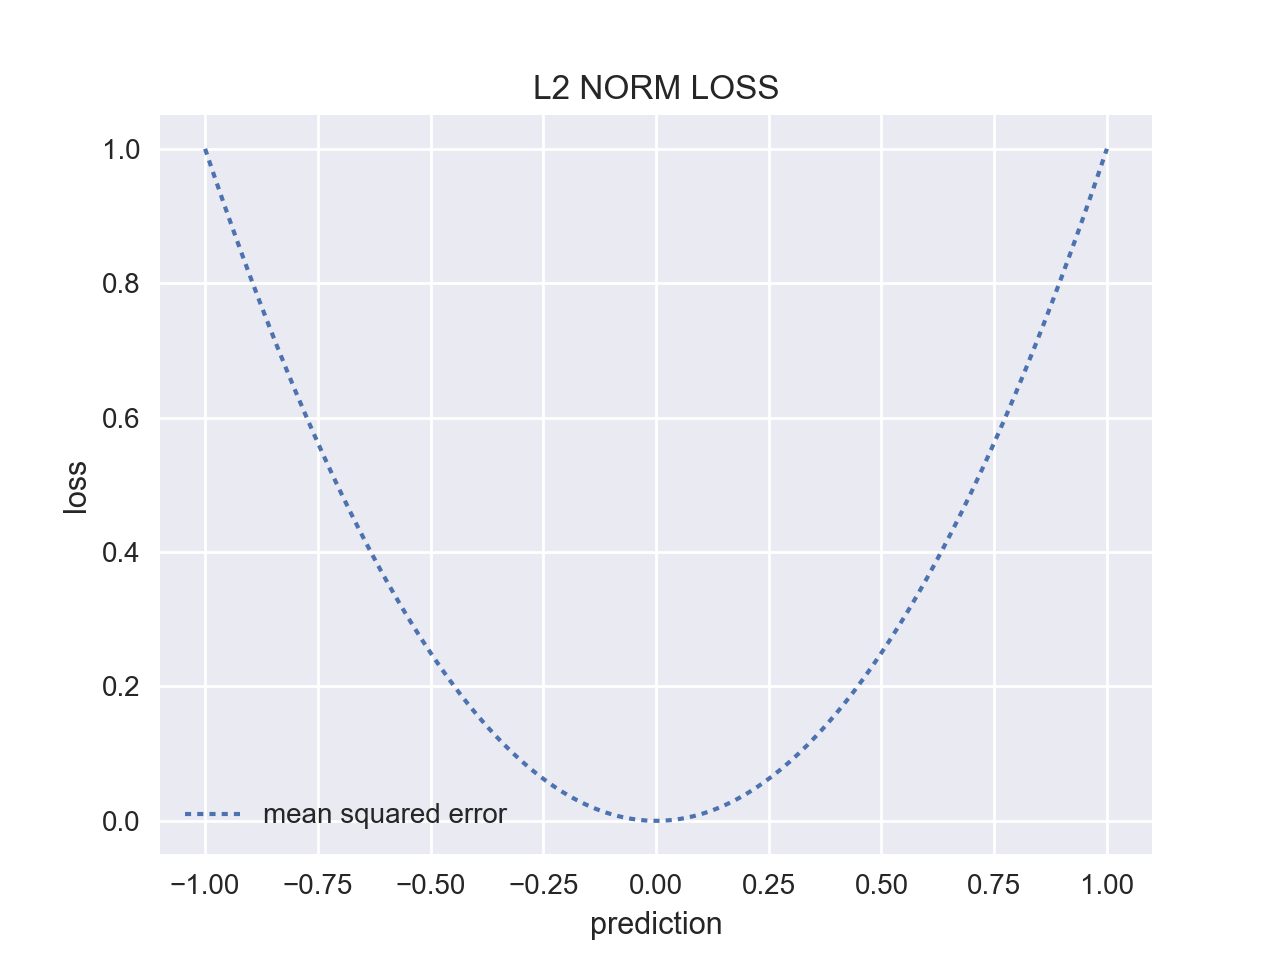

In [7]:
plotRegressionLoss({'fn': tf.losses.mean_squared_error, 'name': 'mean squared error'}, 'L2 NORM LOSS')

### L1 norm loss

The absolute loss function.

Instead of squaring the difference, we take the absolute value. The L1 norm is better for outliers than the L2 norm because it is not as steep for larger values. One issue to be aware of is that the L1 norm is not smooth at the target and this can result in algorithms not converging well.

$$loss = |L - P|$$

where L is labels and P is predictions.

In [8]:
l1_loss_1 = tf.losses.absolute_difference(labels=labels, predictions=predictions, weights=1)
sess.run(l1_loss_1)

0.50505048

In [10]:
l1_loss_2 = tf.reduce_mean(tf.abs(error))
sess.run(l1_loss_2)

0.50505048

<IPython.core.display.Javascript object>


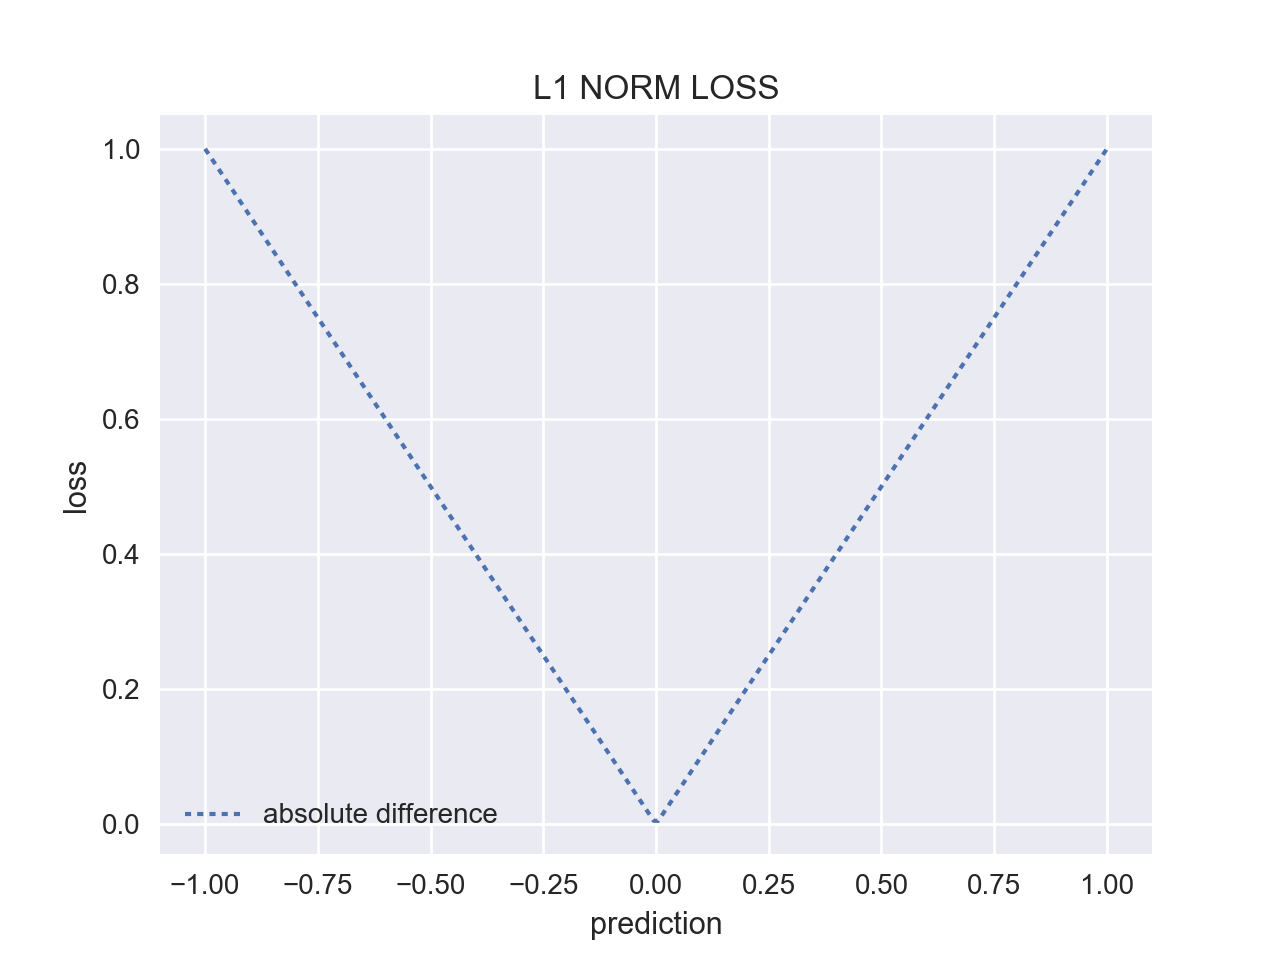

In [11]:
plotRegressionLoss({'fn': tf.losses.absolute_difference, 'name': 'absolute difference'}, 'L1 NORM LOSS')

### Pseudo-Huber loss

A continuous and smooth approximation to the Huber loss function.

This loss function attempts to take the best of the L1 and L2 norms by being convex near the target and less steep for extreme values. The form depends on an extra parameter, delta, which dictates how steep it will be.

$$loss = \delta^2 \times \left(\sqrt{1 + \left(\frac{L-P}{\delta}\right)^2 } - 1\right)$$

where $\delta$ is delta, L is labels, and P is predictions.

In [12]:
def pseudo_huber(delta, labels, predictions, weights=1):
    a = tf.square(delta)
    b = tf.sqrt(1. + tf.square((labels - predictions) / delta))
    c = tf.multiply(a, b - 1.)
    loss = tf.reduce_mean(c)
    return loss

ph0_25 = partial(pseudo_huber, 0.25)
ph5 = partial(pseudo_huber, 5.)

In [13]:
ph_loss_025 = ph0_25(labels, predictions)
sess.run(ph_loss_025)

0.083844975

In [14]:
ph_loss_5 = ph5(labels, predictions)
sess.run(ph_loss_5)

0.16900708

<IPython.core.display.Javascript object>


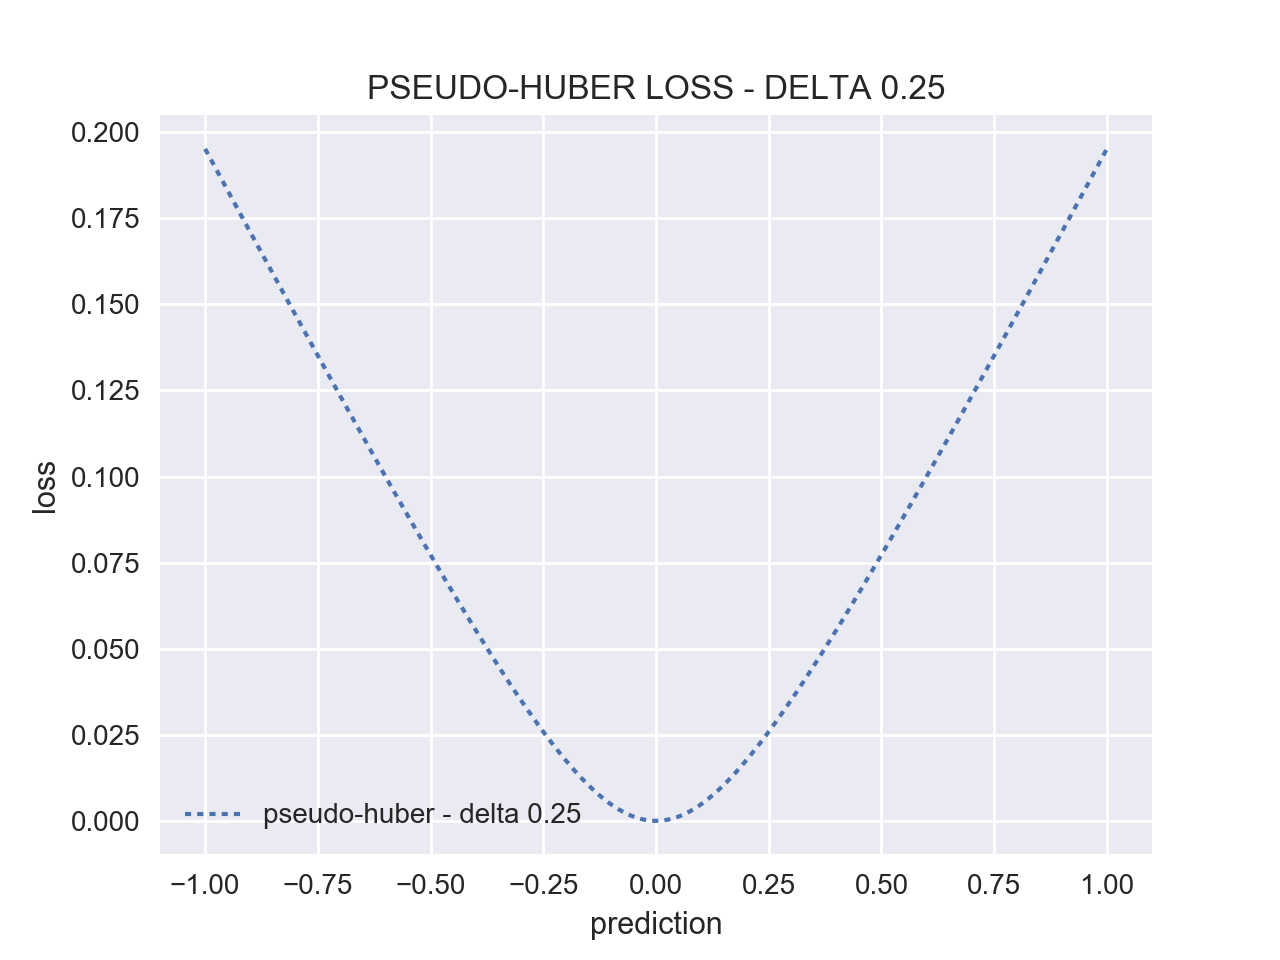

In [15]:
plotRegressionLoss({'fn': ph0_25, 'name': 'pseudo-huber - delta 0.25'}, 'PSEUDO-HUBER LOSS - DELTA 0.25')

<IPython.core.display.Javascript object>


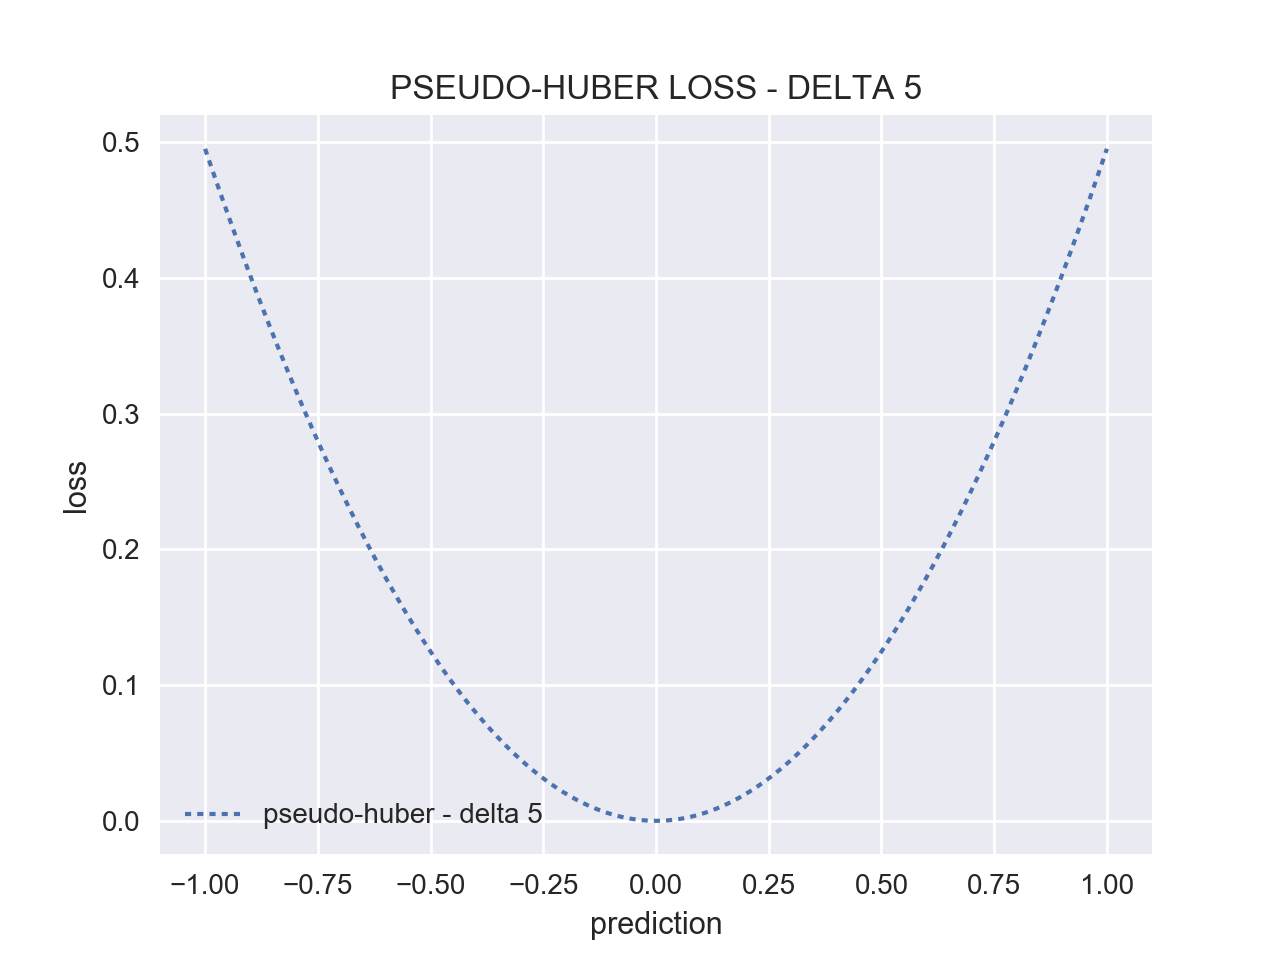

In [16]:
plotRegressionLoss({'fn': ph5, 'name': 'pseudo-huber - delta 5'}, 'PSEUDO-HUBER LOSS - DELTA 5')

## Plotting regression loss functions

<IPython.core.display.Javascript object>


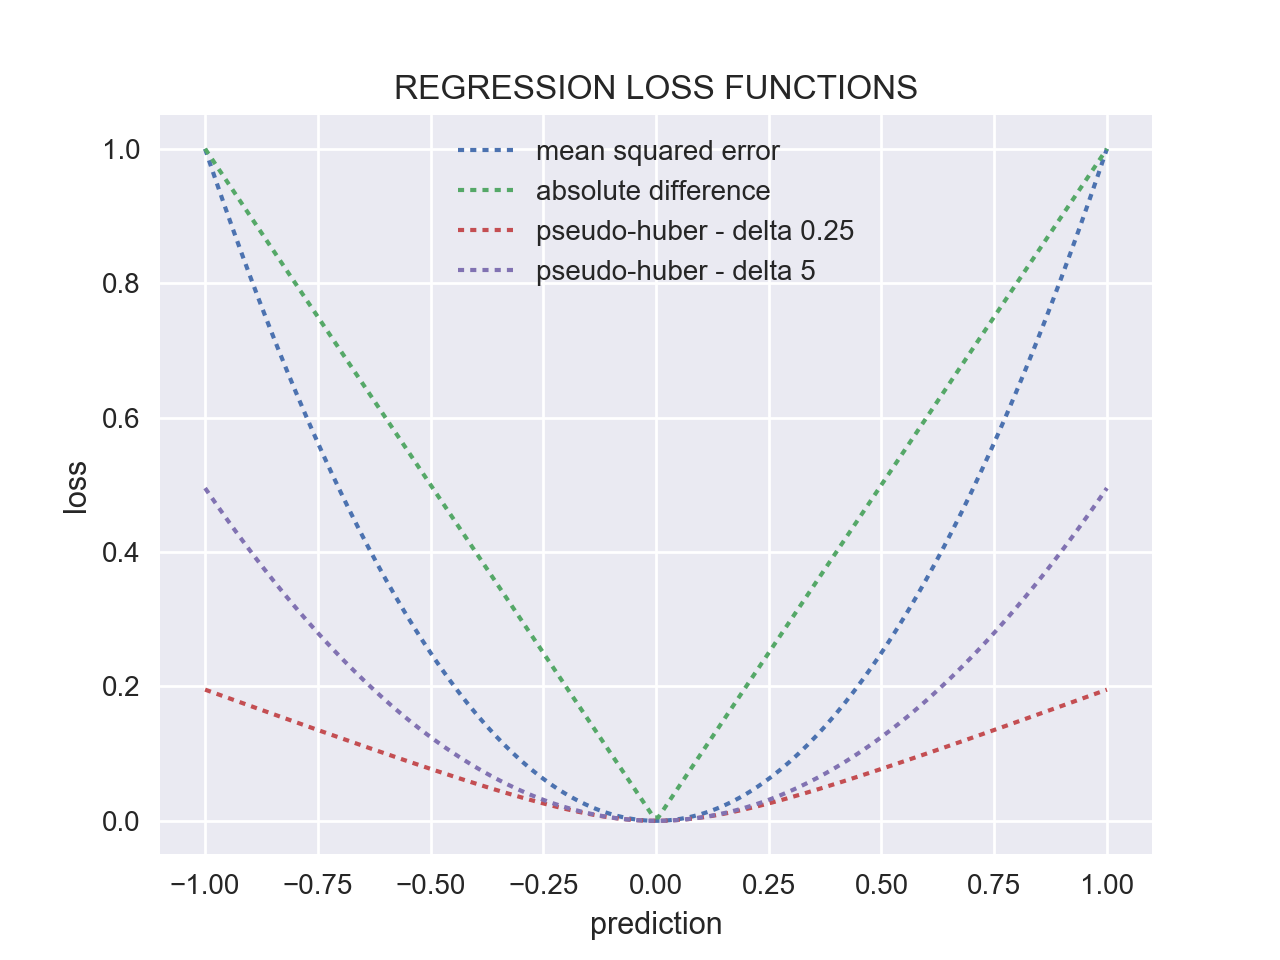

In [44]:
regFnInfos = [
    {'fn': tf.losses.mean_squared_error, 'name': 'mean squared error'},
    {'fn': tf.losses.absolute_difference, 'name': 'absolute difference'},
    {'fn': ph0_25, 'name': 'pseudo-huber - delta 0.25'},
    {'fn': ph5, 'name': 'pseudo-huber - delta 5'}
]

plotRegressionLoss(regFnInfos, 'REGRESSION LOSS FUNCTIONS')

## Loss function for classification

In [17]:
m = 100

outputs = tf.linspace(-3., 3., m)
targets = tf.ones(shape=[n], dtype=tf.float32)

print(outputs)
print(targets)

Tensor("LinSpace_4:0", shape=(100,), dtype=float32)
Tensor("ones:0", shape=(100,), dtype=float32)


In [18]:
def createClassificationFn(fn):
    def runFn(pair):
        return fn(labels=pair[0], logits=pair[1])
    return runFn

def plotClassificationLoss(fnInfos, title='', predictions=None, labels=None, createFn=None):
    n = 200
    
    if predictions is None:
        predictions = tf.linspace(start=-3., stop=5., num=n)
        
    if labels is None:
        labels = tf.fill(value=1., dims=[n])
        
#     if createFn is None:
#         createFn = createClassificationFn
    
    plotLoss(fnInfos=fnInfos, title=title, predictions=predictions, labels=labels, createFn=createFn)

### Hinge loss

Hinge loss is mostly used for support vector machines, but can be used in neural networks as well. It is meant to compute a loss between with two target classes, 1 and -1. In the following code, we are using the target value 1, so the as closer our predictions as near are to 1, the lower the loss value:

$$loss = max\left(0, 1 - L \times P\right)$$

where L is labels and P is predictions.

In [19]:
hinge_loss_1 = tf.losses.hinge_loss(labels=targets, logits=outputs)
sess.run(hinge_loss_1)

1.34

In [20]:
hinge_loss_2 = tf.reduce_mean(tf.maximum(0., 1. - tf.multiply(targets, outputs)))
sess.run(hinge_loss_2)

1.34

<IPython.core.display.Javascript object>


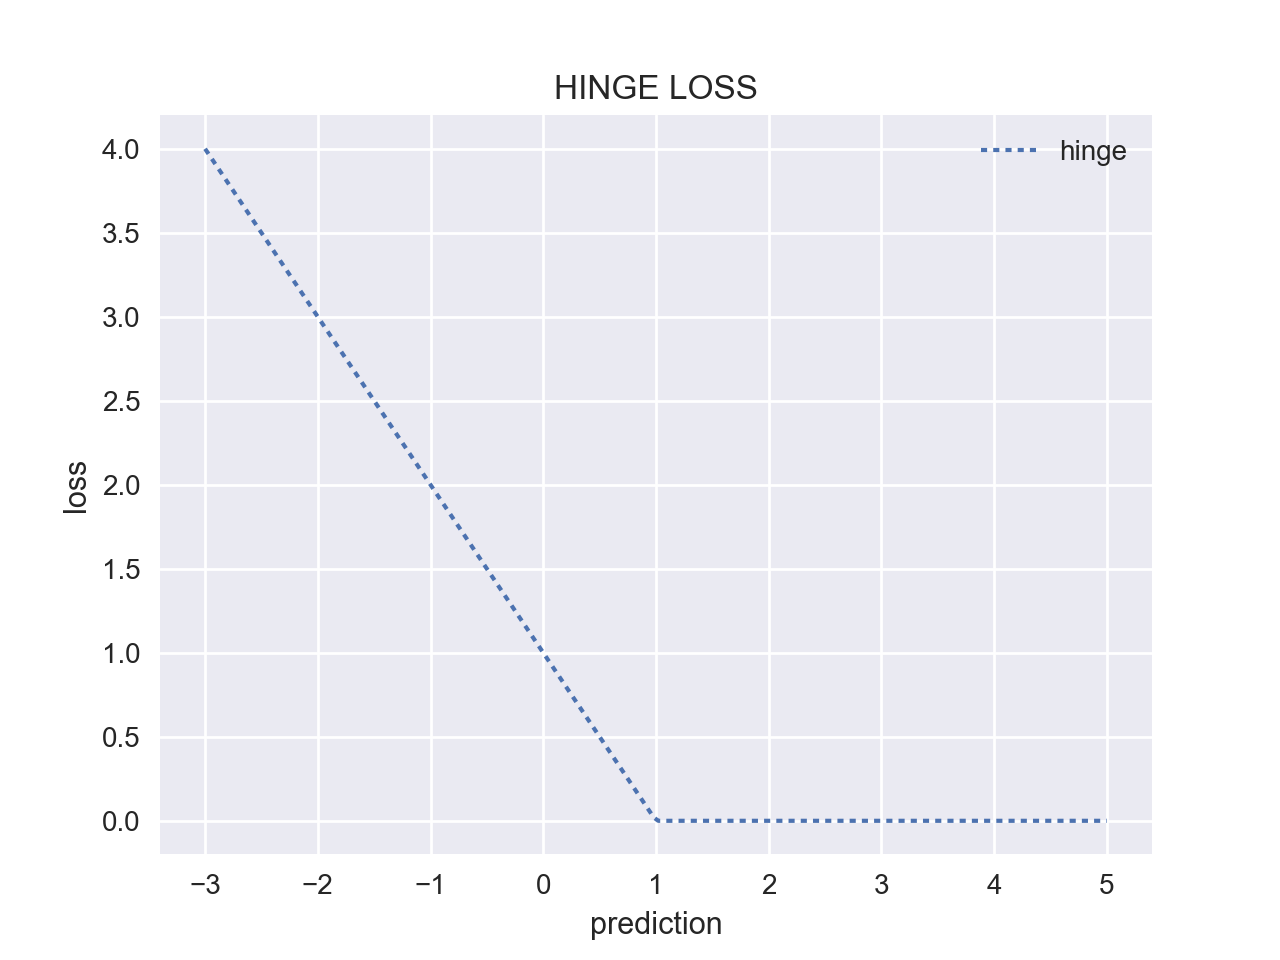

In [21]:
plotClassificationLoss({'fn': tf.losses.hinge_loss, 'name': 'hinge'}, 'HINGE LOSS')

### Cross entropy loss

Cross-entropy loss for a binary case is also sometimes referred to as the logistic loss function. It comes about when we are predicting the two classes 0 or 1. We wish to measure a distance from the actual class (0 or 1) to the predicted value, which is usually a real number between 0 and 1. To measure this distance, we can use the cross entropy formula from information theory, as follows:

$$L \times -\log(P) + (1 - L) \times -\log(1 - P) $$

where L is labels and P is predictions.

In [22]:
def cross_entropy(labels, logits):
    ce = labels * -tf.log(logits) + (1 - labels) * -tf.log(1 - logits)
    return tf.reduce_mean(ce)

In [23]:
ce_loss = cross_entropy(targets, outputs)
sess.run(ce_loss)

nan

<IPython.core.display.Javascript object>


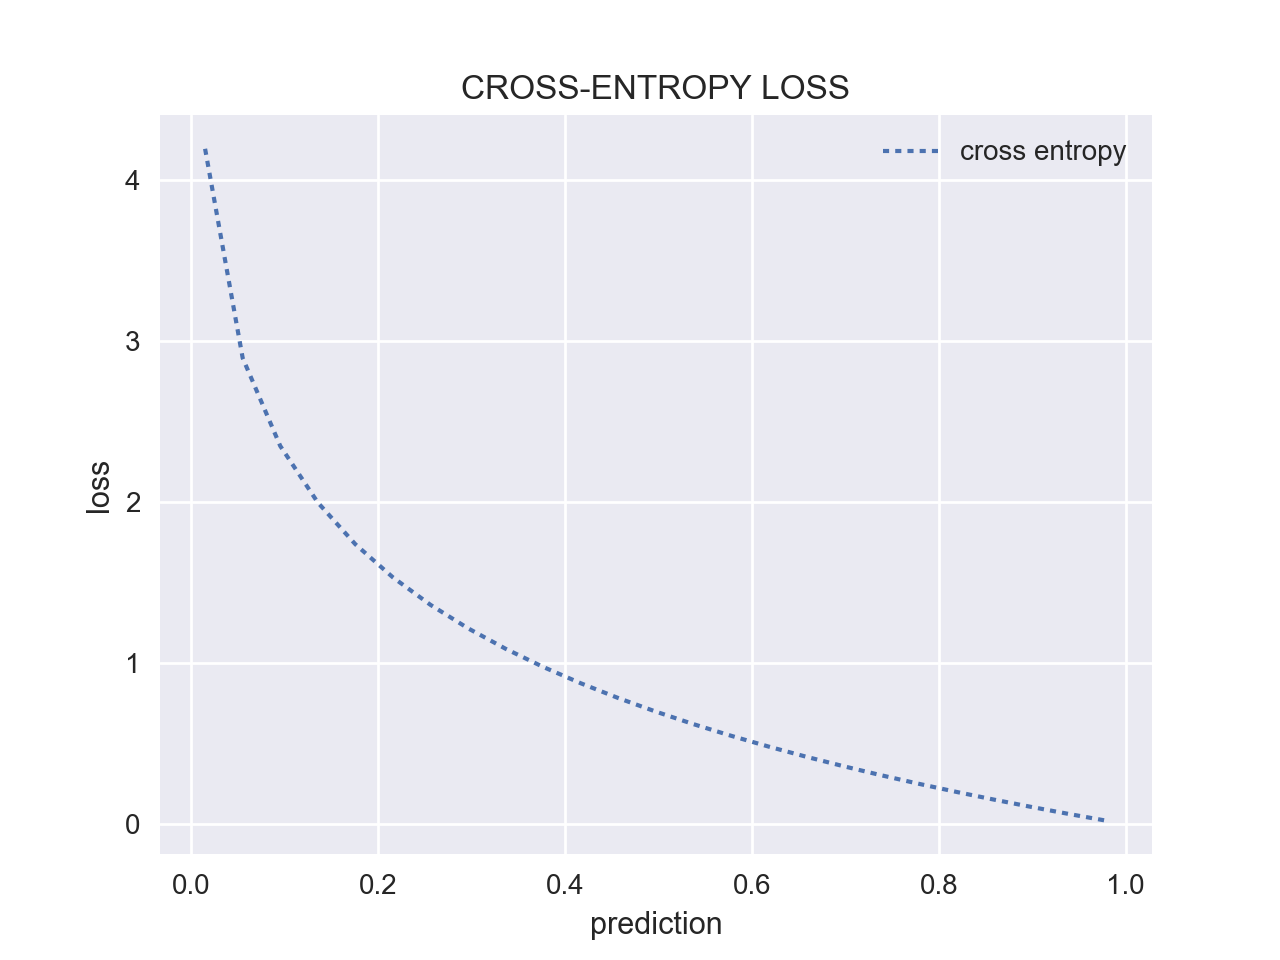

In [24]:
plotClassificationLoss({'fn': cross_entropy, 'name': 'cross entropy'}, 'CROSS-ENTROPY LOSS')

### Sigmoid cross entropy loss

Sigmoid cross entropy loss is very similar to the previous loss function except we transform the x-values by the sigmoid function before we put them in the cross entropy loss, as follows:

$$\sigma = sigmoid(P)$$
$$loss = L \times -\log(\sigma) + (1 - L) \times -\log(1 - \sigma)$$

where L is labels and P is predictions.

In [25]:
sce_loss_1 = tf.losses.sigmoid_cross_entropy(multi_class_labels=targets, logits=outputs)
sess.run(sce_loss_1)

1.0132161

In [26]:
sce_loss_2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=outputs))
sess.run(sce_loss_2)

1.0132161

In [27]:
sigmoid = tf.sigmoid(outputs)
sce = targets * -tf.log(sigmoid) + (1 - targets) * -tf.log(1 - sigmoid)
sce_loss_3 = tf.reduce_mean(sce)
sess.run(sce_loss_3)

1.0132161

<IPython.core.display.Javascript object>


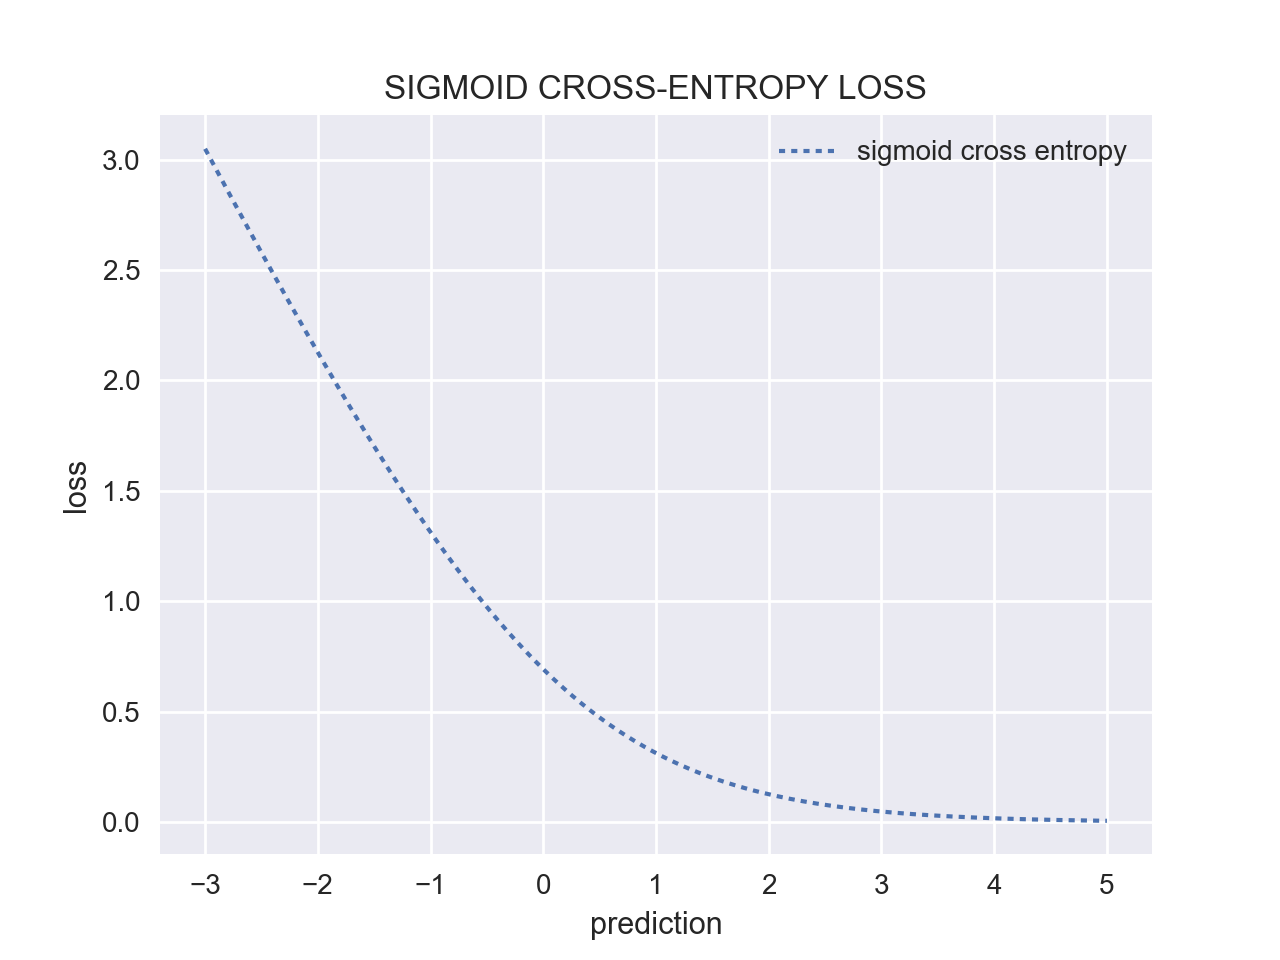

In [28]:
plotClassificationLoss({'fn': tf.losses.sigmoid_cross_entropy, 'name': 'sigmoid cross entropy'}, 'SIGMOID CROSS-ENTROPY LOSS')

### Weighted cross entropy loss

Weighted cross entropy loss is a weighted version of the sigmoid cross entropy loss. We provide a weight on the positive target.

$$\sigma = sigmoid(P)$$
$$loss = L \times -\log(\sigma) \times \omega + (1 - L) \times -\log(1 - \sigma)$$

where L is labels, P is predictions, and $\omega$ is weight.

In [29]:
def wce1(weight, labels, logits):
    wce = tf.nn.weighted_cross_entropy_with_logits(targets=labels, logits=logits, pos_weight=weight)
    return tf.reduce_mean(wce)

def wce2(weight, labels, logits):
    s = tf.sigmoid(logits)
    wce = labels * -tf.log(s) * weight + (1 - labels) * -tf.log(1 - s)
    return tf.reduce_mean(wce)

wce_05 = partial(wce1, 0.5)
wce_20 = partial(wce2, 2.0)

In [30]:
wce_loss_05_1 = wce_05(targets, outputs)
sess.run(wce_loss_05_1)

0.50660807

In [31]:
wce_loss_05_2 = wce2(0.5, targets, outputs)
sess.run(wce_loss_05_2)

0.50660807

In [32]:
wce_loss_20_1 = wce_20(targets, outputs)
sess.run(wce_loss_20_1)

2.0264323

In [33]:
wce_loss_20_2 = wce1(2.0, targets, outputs)
sess.run(wce_loss_20_2)

2.0264323

<IPython.core.display.Javascript object>


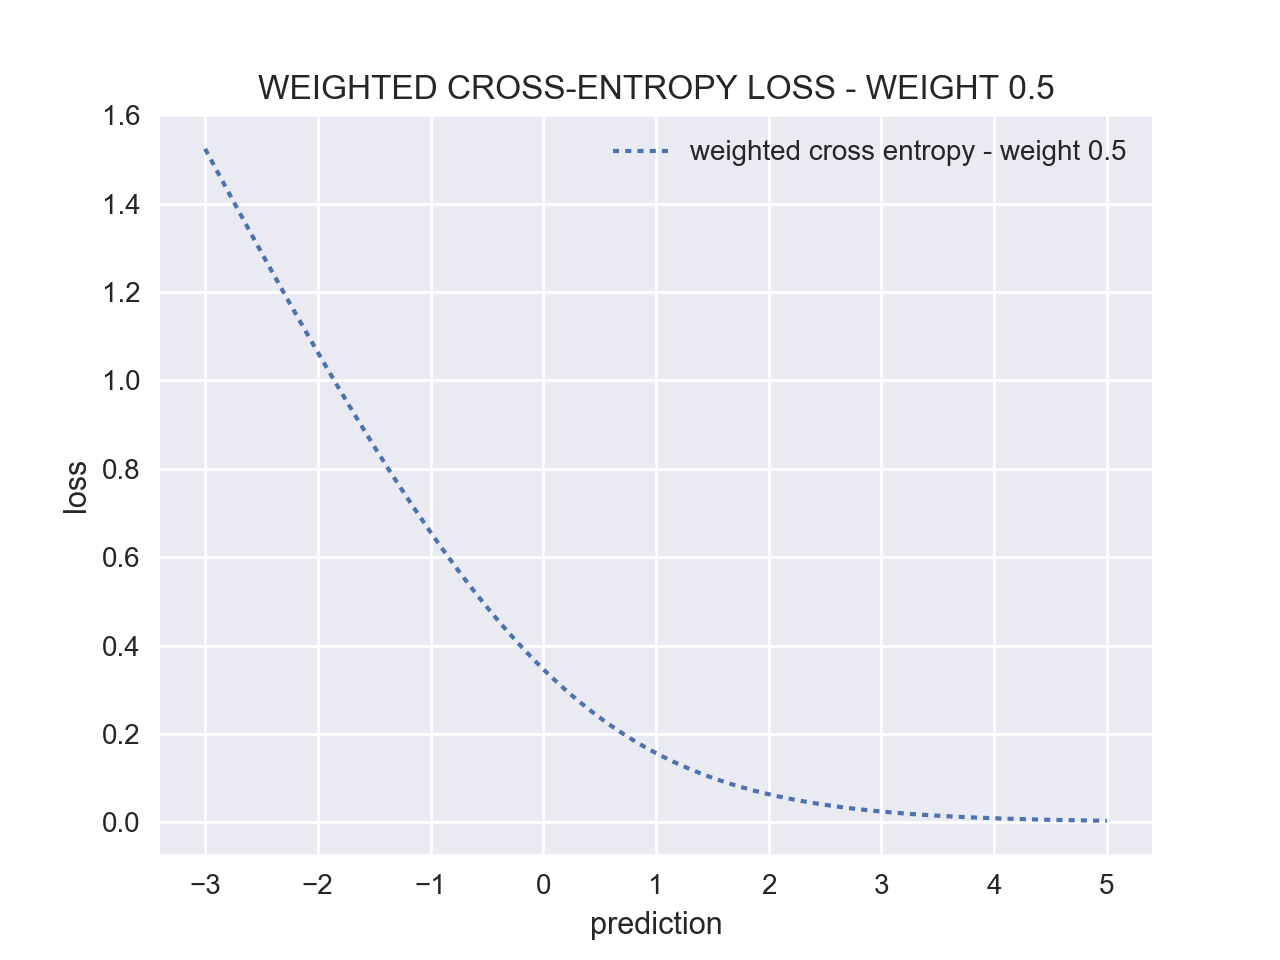

In [34]:
plotClassificationLoss({'fn': wce_05, 'name': 'weighted cross entropy - weight 0.5'}, 'WEIGHTED CROSS-ENTROPY LOSS - WEIGHT 0.5')

<IPython.core.display.Javascript object>


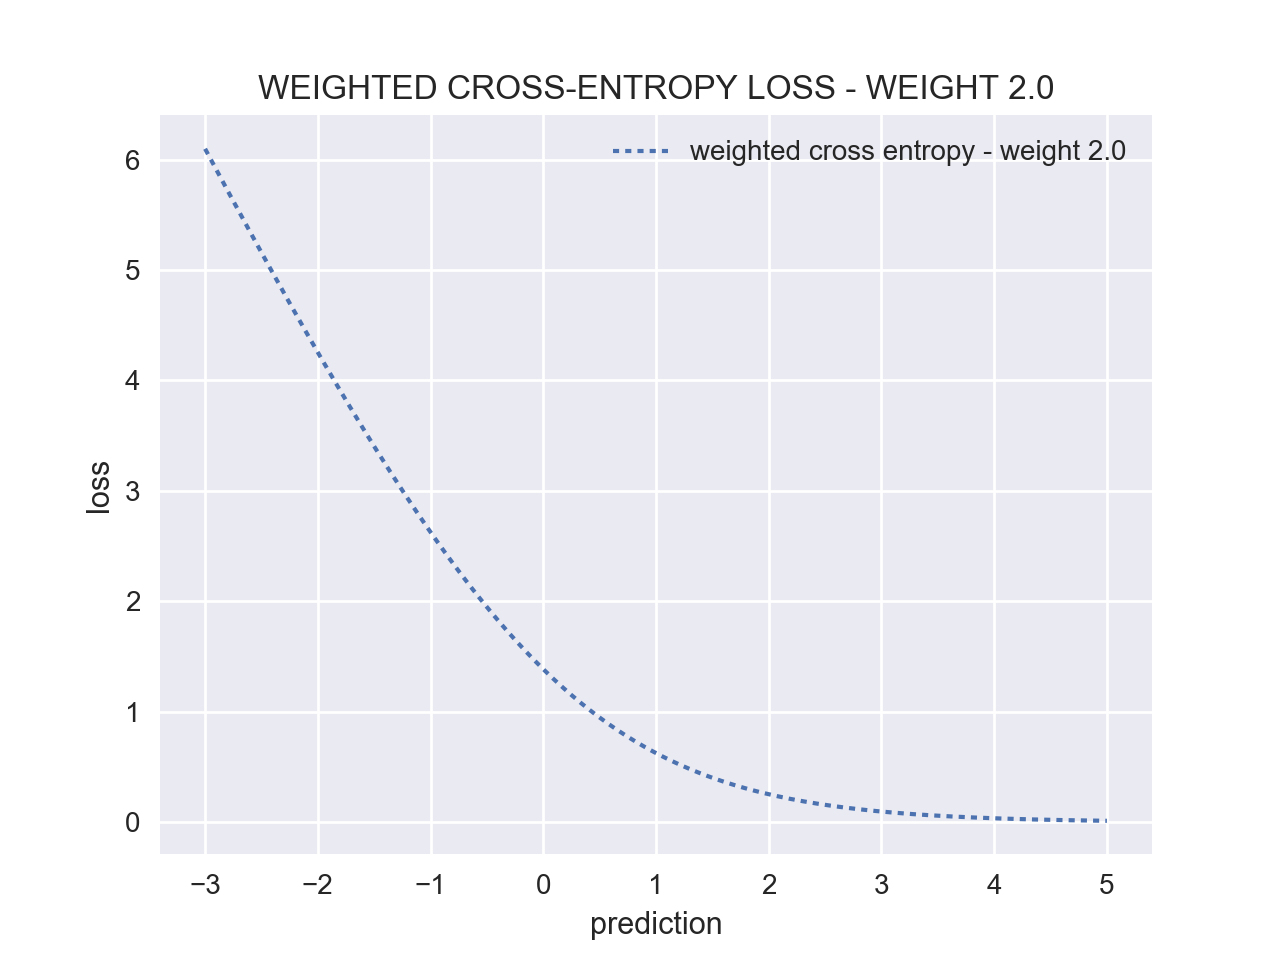

In [35]:
plotClassificationLoss({'fn': wce_20, 'name': 'weighted cross entropy - weight 2.0'}, 'WEIGHTED CROSS-ENTROPY LOSS - WEIGHT 2.0')

## Plotting various classification loss functions

<IPython.core.display.Javascript object>


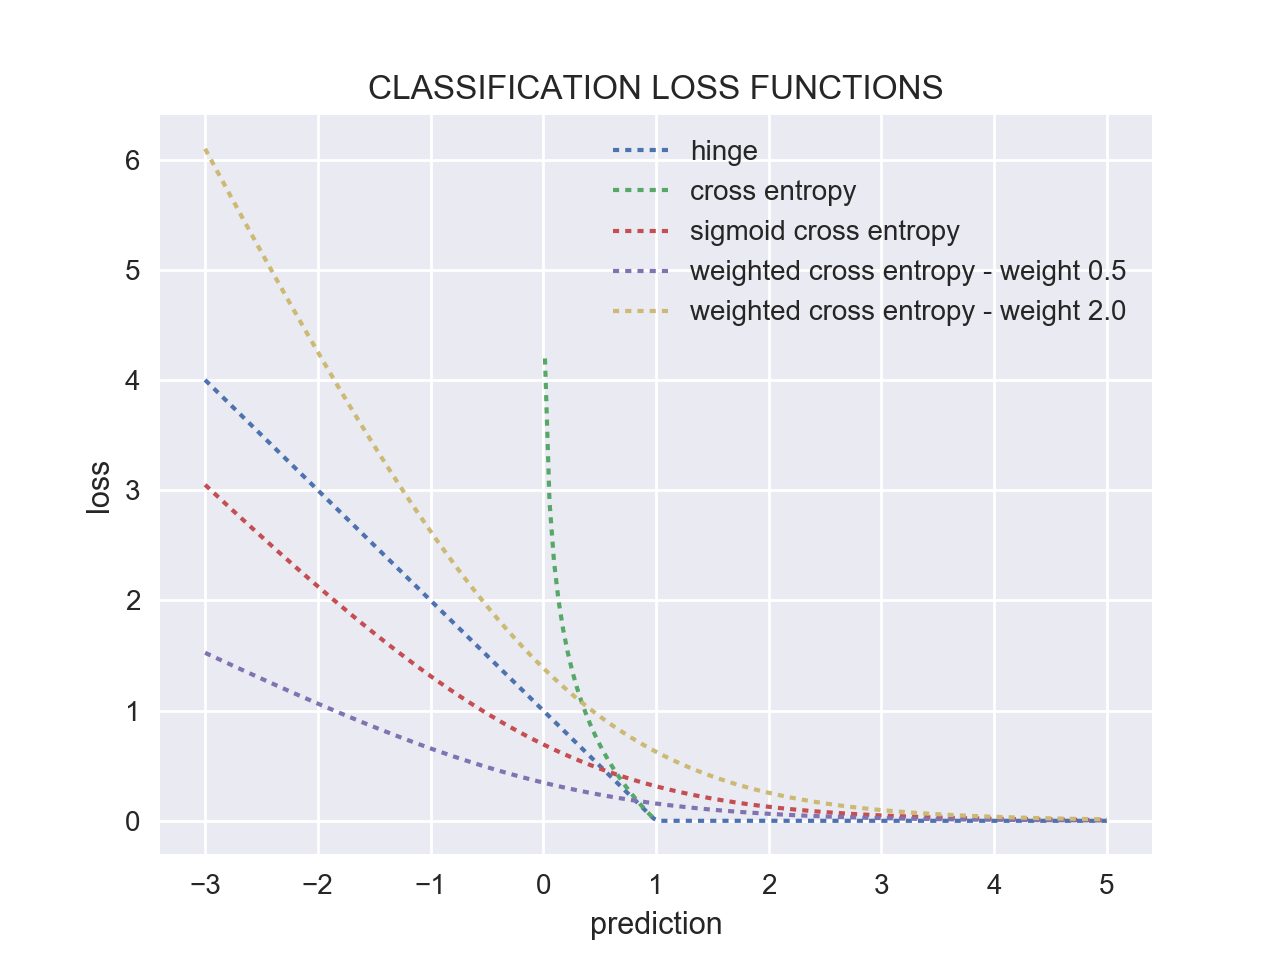

In [45]:
clsFnInfos = [
    {'fn': tf.losses.hinge_loss, 'name': 'hinge'},
    {'fn': cross_entropy, 'name': 'cross entropy'},
    {'fn': tf.losses.sigmoid_cross_entropy, 'name': 'sigmoid cross entropy'},
    {'fn': wce_05, 'name': 'weighted cross entropy - weight 0.5'},
    {'fn': wce_20, 'name': 'weighted cross entropy - weight 2.0'}
]

plotClassificationLoss(clsFnInfos, 'CLASSIFICATION LOSS FUNCTIONS')

### Softmax cross entropy loss

Softmax cross-entropy loss operates on non-normalized outputs. This function is used to measure a loss when there is only one target category instead of multiple. Because of this, the function transforms the outputs into a probability distribution via the softmax function and then computes the loss function from a true probability distribution, as follows:

In [36]:
soce_loss_1 = tf.losses.softmax_cross_entropy(targets, outputs)
sess.run(soce_loss_1)

583.11755

In [37]:
soce_loss_1 = tf.nn.softmax_cross_entropy_with_logits(labels=targets, logits=outputs)
sess.run(soce_loss_1)

583.11755

### Sparse softmax cross-entropy loss

Sparse softmax cross-entropy loss is the same as previously, except instead of the target being a probability distribution, it is an index of which category is true. Instead of a sparse all-zero target vector with one value of one, we just pass in the index of which category is the true value, as follows:

In [40]:
lbls = tf.constant([1], name='lbls')
logs = tf.constant([[1., -2., 3.]], name='logs')
print(lbls)
print(logs)

Tensor("lbls_1:0", shape=(1,), dtype=int32)
Tensor("logs_1:0", shape=(1, 3), dtype=float32)


In [41]:
ssce_loss_1 = tf.losses.sparse_softmax_cross_entropy(labels=lbls, logits=logs)
sess.run(ssce_loss_1)

5.1328454

In [42]:
ssce_loss_2 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=lbls, logits=logs)
sess.run(ssce_loss_2)

array([ 5.1328454], dtype=float32)